In [4]:
%cd "~/lab/NB10422645"
from src.surrogate.sampling import uniform_grid
from src.surrogate.tools.matlab import grid_design_to_folder
from src.surrogate.tools.matlab import designs_to_folder
from src.surrogate.tools.matlab import idoe_ug_screening
from src.optimisation.constructor.examples import rs_bicycle_constructor
from scipy.io import savemat, loadmat

/home/ggarrett/lab/NB10422645


In [2]:
%%time

N = 3
S = 5
APP = "rs_bicycle"
idoe_ug_screening(APP, N, S)


CPU times: user 168 ms, sys: 54.4 ms, total: 222 ms
Wall time: 51.2 s


In [4]:
%%time

N = 3
S = 10
APP = "rs_bicycle"
idoe_ug_screening(APP, N, S)


CPU times: user 673 ms, sys: 346 ms, total: 1.02 s
Wall time: 6min 29s


In [3]:
%%time

N = 3
S = 15
APP = "rs_bicycle"
idoe_ug_screening(APP, N, S)


CPU times: user 2.74 s, sys: 1.63 s, total: 4.37 s
Wall time: 30min 45s


In [4]:
%%time

N = 3
S = 20
APP = "rs_bicycle"
idoe_ug_screening(APP, N, S)


CPU times: user 4.98 s, sys: 3.51 s, total: 8.49 s
Wall time: 1h 5min 45s


In [ ]:
%%time

N = 3
S = 25
APP = "rs_bicycle"
idoe_ug_screening(APP, N, S)

In [1]:

%cd "~/lab/NB10422645"

from src.surrogate.algorithms import ssifl
from src.surrogate.test import TestFunctionSet2DInputSpace
F2D = TestFunctionSet2DInputSpace()


/home/ggarrett/lab/NB10422645


/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
%%time

%cd "~/lab/NB10422645"

from src.surrogate.algorithms import ssifl2
from src.surrogate.models import RandomForestRegression, SupportVectorRegression, FeedForwardNNRegression
from src.surrogate.test import TestFunctionSet2DInputSpace
F2D = TestFunctionSet2DInputSpace()

# from src.
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scalert1_1=MinMaxScaler(feature_range=(0,1))
scalert1_2=MinMaxScaler(feature_range=(0,1))

model_t1_1 = ssifl2(epsilon=0.3, 
                  delta=1-0.95, 
                  function=F2D[0], 
                  n=2,
                  hpopt=True, 
                  model_handle_cls=SupportVectorRegression, 
                  scaler=scalert1_1,
                  path="./test1.sv")

model_t1_2 = ssifl2(epsilon=0.3, 
                  delta=1-0.95, 
                  function=F2D[0], 
                  n=2,
                  hpopt=True, 
                  model_handle_cls=FeedForwardNNRegression, 
                  scaler=scalert1_2,
                  path="./test2.sv")

# model_f3 = ssifl2(epsilon=epsilon, 
#                   delta=delta, 
#                   function=f3,  
#                   n=3,
#                   hpopt=True, 
                  
#                   model_handle_cls=FeedForwardNNRegression, 
#                   scaler=scalerf3,
# #                   dim_reduction=0,
#                   path="./test_f3.sv")

/home/ggarrett/lab/NB10422645


+------+---------+--------------------+----------+------------------------------+
| iter | s_train | n_s_test < epsilon | n_s_test | Pr(|fsm(x)-f(x)| <= epsilon) |
+------+---------+--------------------+----------+------------------------------+
|  1   |   25    |         4          |    7     |            0.571             |


|  2   |   36    |         9          |    10    |             0.9              |


|  3   |   49    |         13         |    14    |            0.929             |


|  4   |   64    |         18         |    18    |             1.0              |
+------+---------+--------------------+----------+------------------------------+
|  4   |   64    |         18         |    18    |             1.0              |
+------+---------+--------------------+----------+------------------------------+


+------+---------+--------------------+----------+------------------------------+
| iter | s_train | n_s_test < epsilon | n_s_test | Pr(|fsm(x)-f(x)| <= epsilon) |
+------+---------+--------------------+----------+------------------------------+
|  1   |   25    |         0          |    7     |             0.0              |


|  2   |   36    |         9          |    10    |             0.9              |


|  3   |   49    |         3          |    14    |            0.214             |


|  4   |   64    |         17         |    18    |            0.944             |


/home/ggarrett/lab/NB10422645
False


+------+---------+--------------------+----------+------------------------------+
| iter | s_train | n_s_test < epsilon | n_s_test | Pr(|fsm(x)-f(x)| <= epsilon) |
+------+---------+--------------------+----------+------------------------------+
|  0   |   784   |        581         |   729    |            0.797             |


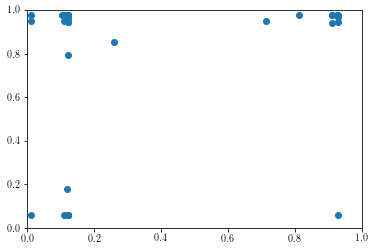

/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning:

The objective has been evaluated at this point before.



|  1   |   841   |        594         |   741    |            0.802             |


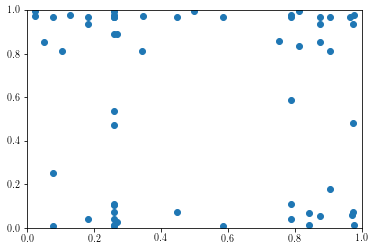

|  2   |   900   |        617         |   753    |            0.819             |


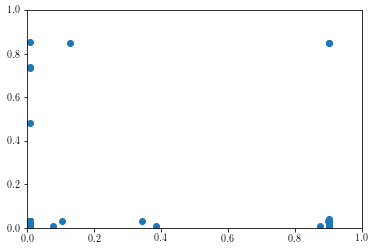

|  3   |   961   |        636         |   766    |             0.83             |


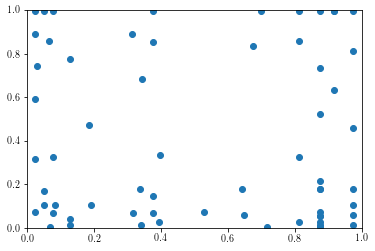

|  4   |  1024   |        650         |   779    |            0.834             |


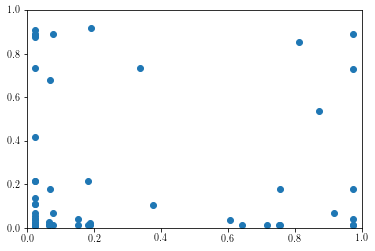

|  5   |  1089   |        669         |   792    |            0.845             |


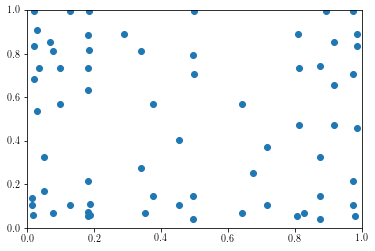

|  6   |  1156   |        697         |   806    |            0.865             |


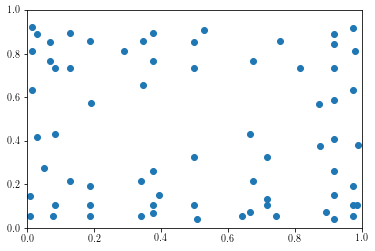

|  7   |  1225   |        723         |   820    |            0.882             |


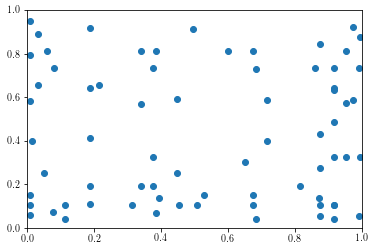

|  8   |  1296   |        753         |   835    |            0.902             |


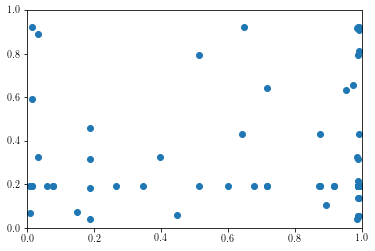

|  9   |  1369   |        770         |   850    |            0.906             |


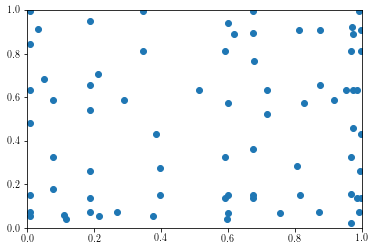

|  10  |  1444   |        796         |   865    |             0.92             |


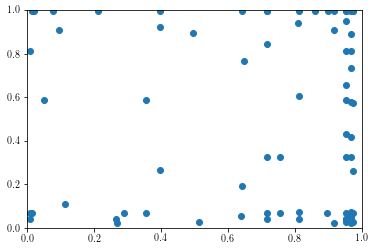

|  11  |  1521   |        824         |   881    |            0.935             |


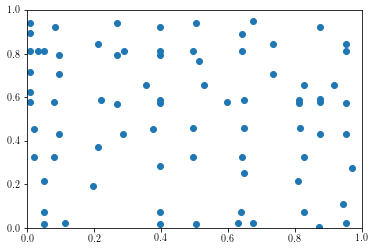

|  12  |  1600   |        845         |   897    |            0.942             |


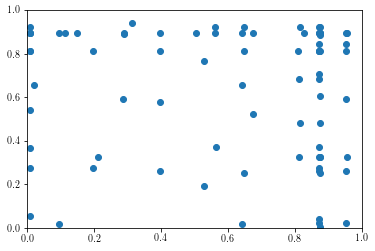

|  13  |  1681   |        872         |   914    |            0.954             |
EvaluationLog(n_samples=10000, n_passing=9091, statistic=0.9091, terminate=False)


In [26]:
%matplotlib inline
%cd "~/lab/NB10422645"
import matplotlib

import torch
print(torch.cuda.is_available())

from src.surrogate.meta_models import SupportVectorRegression as svr
from src.surrogate.meta_models import FeedForwardNNRegression as ffn

from src.surrogate.test import TestFunctionSet2DInputSpace as F2D
from sklearn.preprocessing import MinMaxScaler
from src.surrogate.algorithms import SSIFL

scaler = MinMaxScaler()

F2D = F2D()

# test.meta_model.static_params["learning_rate"]=1e-4

# %cd "~/lab/NB10422645"
# from src.surrogate.algorithms import ssifl
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from src.utils.matlab import idx_target_sim_func

f1=idx_target_sim_func(0, tag="f1")
f2=idx_target_sim_func(1, tag="f2")
f3=idx_target_sim_func(2, tag="f3")

test = SSIFL(func=F2D.HolderTable,
             x_dim=2,
             meta_model=svr(),
             delta=0.05,
             epsilon=0.05,
             verbose=True,
             scaler=scaler)

test.iterate_to_confidence(cumulative=True, 
                           verbose=10,
                           importance="error",
                           hopt=True)

# Sample initial design of experiments using CVT.|
x_test = test.sample(10000,
                     "halton", seed=1, tdmq=False,
                     verbose=False)

# Evaluate the experiments.
f_test = test.func(*x_test.T)

print(test.pacc_evaluate(test.scaler.transform(f_test.reshape(-1,1)).flatten(),
                         test.meta_model.predict(x_test),
                         test.epsilon,
                         test.delta))



In [6]:
scaler = MinMaxScaler()

# F2D = F2D()

test.meta_model.static_params["learning_rate"]=1e-2

test.iterate_to_confidence(cumulative=True, 
                           verbose=10,
                           importance="error",
                           hopt=False)

# test = SSIFL(func=F2D[0],
#              x_dim=2,
#              meta_model=svr(),
#              delta=0.0001,
#              epsilon=0.05,
#              verbose=True,
#              scaler=scaler)

# test.iterate_to_confidence(cumulative=False, verbose=True,
#                            importance="none", hopt=False)

# # Sample initial design of experiments using CVT.
# x_test = test.sample(10000,
#                      "halton", seed=1, tdmq=False,
#                      verbose=False)

# # Evaluate the experiments.
# f_test = test.func(*x_test.T)

# print(test.pacc_evaluate(test.scaler.transform(f_test.reshape(-1,1)).flatten(),
#                          test.meta_model.predict(x_test),
#                          test.epsilon,
#                          test.delta
#                          )
#       )


Epoch [  1  / 400 ]  |  Train Loss:  1.182157  |  Validation Loss:  0.205107  |  lr:  0.01000
Epoch [ 11  / 400 ]  |  Train Loss:  0.034043  |  Validation Loss:  0.028685  |  lr:  0.01000
Epoch [ 21  / 400 ]  |  Train Loss:  0.033998  |  Validation Loss:  0.027261  |  lr:  0.01000
Epoch [ 31  / 400 ]  |  Train Loss:  0.032275  |  Validation Loss:  0.042797  |  lr:  0.01000
Epoch [ 41  / 400 ]  |  Train Loss:  0.026994  |  Validation Loss:  0.023338  |  lr:  0.01000
Epoch [ 51  / 400 ]  |  Train Loss:  0.026100  |  Validation Loss:  0.019470  |  lr:  0.01000
Epoch [ 61  / 400 ]  |  Train Loss:  0.028368  |  Validation Loss:  0.025982  |  lr:  0.01000
Epoch [ 71  / 400 ]  |  Train Loss:  0.025000  |  Validation Loss:  0.018289  |  lr:  0.01000
Epoch [ 81  / 400 ]  |  Train Loss:  0.025460  |  Validation Loss:  0.017457  |  lr:  0.01000
Interrupted


SystemExit: 0

/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



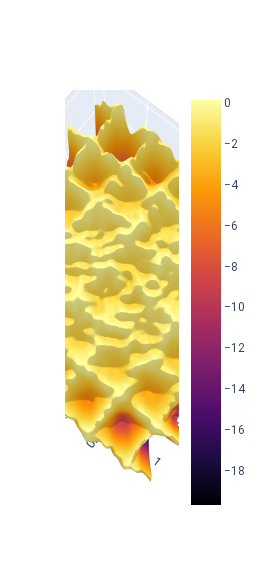

In [28]:
import numpy as np
from src.surrogate.sampling import uniform_grid
from src.surrogate.sampling.util import plotly3Dsurf, plotly3Dtrisurf
    
def compare(n, model, scaler):
    
    bounds = np.array([[0]*n,[1]*n])
    X = uniform_grid(bounds, 100, flatten=False)
    
    X_ = uniform_grid(bounds, 100, flatten=True)

    def vec_eval(x):
        return model.predict(x)
    F=vec_eval(X_)
    if scaler:
        plotly3Dsurf(X[0], X[1], scaler.inverse_transform(F.reshape(-1,1)).reshape(100,100))
    
    else:
        plotly3Dsurf(X[0], X[1], F.reshape(100,100))
        

# load_test = 
# compare(2, model_t1_1, scalert1_1)
# compare(2, model_t1_2, scalert1_2)
compare(2, test.meta_model, test.scaler)

In [1]:

%cd "~/lab/NB10422645"
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from src.surrogate.sampling import uniform_grid
from src.surrogate.sampling import InterpolatedMarginalInverseECDF

x = uniform_grid([[0, 0], [1, 1]], edges=True, n_sample=20)
p = np.sqrt((x.T[0] - 0.5) ** 2 + (x.T[1] - 0.5) ** 2).flatten()
# print(p.shape)
# print(p)
# print(p)

test = InterpolatedMarginalInverseECDF(-p, x, kind='linear')

# print(x)
# print(test(x))
# print(test(x))
# plt.scatter(*test(x).T)

plt.plot(np.linspace(0, 1, 100),
         test._interpolations[1](np.linspace(0, 1, 100)))

# plt.scatter(*x.T)
# plt.show()

/home/ggarrett/lab/NB10422645


In [10]:
%%timeit

UsageError: %%timeit is a cell magic, but the cell body is empty. Did you mean the line magic %timeit (single %)?


In [ ]:
%%time

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scalert2=MinMaxScaler(feature_range=(0,10))
model_t2 = ssifl(0.05, 1-0.95, F2D[0], 2, optimize_hp=True, scaler=scalert2)

In [ ]:
%%time

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scalerR2d=MinMaxScaler(feature_range=(0,10))
model_r2d = ssifl(0.1, 1-0.95, F2D[3], 2, optimize_hp=True, scaler=scalerR2d)

In [3]:
from src.surrogate.test import Rosenbrock
import numpy as np

Rosenbrock3D = Rosenbrock(3)
Rosenbrock5D = Rosenbrock(5)
Rosenbrock7D = Rosenbrock(7)
Rosenbrock9D = Rosenbrock(9)

In [1]:
%%time

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scalerR3d=MinMaxScaler(feature_range=(0,10))
model_r3d = ssifl(0.1, 1-0.95, Rosenbrock3D, 3, optimize_hp=True, scaler=scalerR3d)

NameError: name 'ssifl' is not defined

In [7]:
%%time

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scalerR5d=MinMaxScaler(feature_range=(0,10))
model_r5d = ssifl(0.1, 1-0.95, Rosenbrock5D, 5, optimize_hp=True, scaler=scalerR5d)

model_r5d.predict((np.array([1,1,1,1,1])-Rosenbrock5D.bounds[0])/(Rosenbrock5D[1]-Rosenbrock5D[0]))


+------+---------+--------------------+----------+------------------------------+
| iter | s_train | n_s_test < epsilon | n_s_test | Pr(|fsm(x)-f(x)| <= epsilon) |
+------+---------+--------------------+----------+------------------------------+
|  1   |   243   |         41         |    61    |            0.672             |
|  2   |  1024   |        251         |   257    |            0.977             |
+------+---------+--------------------+----------+------------------------------+
|  2   |  1024   |        251         |   257    |            0.977             |
+------+---------+--------------------+----------+------------------------------+


TypeError: 'Rosenbrock' object is not subscriptable

In [4]:
%%time

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scalerR7d=MinMaxScaler(feature_range=(0,10))
model_r7d = ssifl(0.1, 1-0.95, Rosenbrock7D, 7, optimize_hp=True, scaler=scalerR7d)

KeyboardInterrupt: 

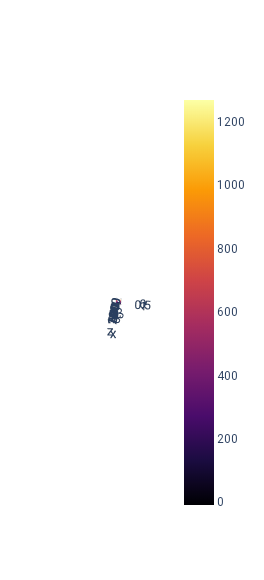

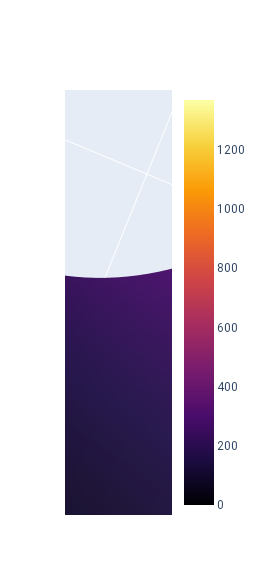

In [13]:
from src.surrogate.sampling import uniform_grid
from src.surrogate.sampling.util import plotly3Dsurf, plotly3Dtrisurf

X = uniform_grid(F2D[3].norm_bounds, 100, flatten=False)
X_ = uniform_grid(F2D[3].norm_bounds, 100, flatten=True)


import numpy as np

def vec_eval(x):
    return model_r2d.predict(x)


F=vec_eval(X_)

plotly3Dsurf(X[0], X[1], scalerR2d.inverse_transform(F.reshape(-1,1)).reshape(100,100))
plotly3Dsurf(X[0], X[1], F2D[3](X[0],X[1]))



In [2]:
%cd "~/lab/NB10422645"
from src.surrogate.algorithms import ssifl
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from src.surrogate.tools.matlab import idx_target_sim_func

f1=idx_target_sim_func(0, tag="f1")
f2=idx_target_sim_func(1, tag="f2")
f3=idx_target_sim_func(2, tag="f3")


scaler=MinMaxScaler(feature_range=(0,10))

/home/ggarrett/lab/NB10422645


/home/ggarrett/anaconda3/envs/sigh/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
%%time

# from matlab import engine

# engine.work


scalerf1=MinMaxScaler(feature_range=(0,1))
scalerf2=MinMaxScaler(feature_range=(0,1))
scalerf3=MinMaxScaler(feature_range=(0,1))

from src.surrogate.algorithms import ssifl2
from src.surrogate.models import FeedForwardNNRegression, RandomForestRegression, SupportVectorRegression
from src.surrogate.test import TestFunctionSet2DInputSpace

# model_f2 = ssifl(0.20, 0.20, f2, 3, optimize_hp=True, scaler=scalerf2)

epsilon = 0.3
delta = 0.05

# model_f1 = ssifl2(epsilon=epsilon, 
#                   delta=delta, 
#                   function=f1, 
#                   n=3,
#                   hpopt=True, 
#                   model_cls=SupportVectorRegression, 
#                   scaler=scalerf1,
#                   path="./test_f1.sv")

# model_f1 = ssifl2(epsilon=epsilon, 
#                   delta=delta, 
#                   function=f2, 
#                   n=3,
#                   hpopt=True, 
#                   model_cls=SupportVectorRegression, 
#                   scaler=scalerf2,
#                   path="./test_f2.sv")

model_f3 = ssifl2(epsilon=epsilon, 
                  delta=delta, 
                  function=f3,  
                  n=3,
                  hpopt=True, 
                  
                  model_handle_cls=FeedForwardNNRegression, 
                  scaler=scalerf3,
#                   dim_reduction=0,
                  path="./test_f3.sv")

|  6   |   512   |         25         |   131    |            0.191             |


In [4]:
### from src.surrogate.sampling import random_uniform
from src.surrogate.sampling.util import plotly3Dsurf, plotly3Dtrisurf
from src.surrogate.test import *
import os

N=3
S=20
tag = f"_UG_N{N}_S{S}"
ROOT_DIR="simulation"
EVAL_DIR="data/rs_bicycle/idoe"
APP_DIR= "apps"
APP='rs_bicycle'
    
res = loadmat( os.path.join(ROOT_DIR, EVAL_DIR, f'{APP + tag}.mat'))

X = res["X"]
X_ = X
F = res["F"]
s = 1
fn = 7

X=X.reshape(3,S,S,S)

f_ = F[:,fn].reshape(S,S,S)

# print(f_s
f_ = f_[:,:,s]

grid=uniform_grid([[0]*3,[1]*3], S, flatten=False)

x, y = grid[0][:,:,s], grid[1][:,:,s]
# print(grid[0].flatten())
plotly3Dtrisurf(x, y, f_, save=False)


from sklearn.svm import SVR
import numpy as np

clf = SVR(gamma='scale', C=1.0, epsilon=0.2, kernel="linear")

clf.fit(X_, F[:,fn]) 

px = x
py = y
pz = clf.predict(X_).flatten().reshape(S,S,S)[:,:,s]


print(px.shape)
print(py.shape)

print(pz.shape)

plotly3Dtrisurf(x.flatten(), y.flatten(), pz, save=False)
clf.score(X_,F[:,fn])

# clf.predict()
# SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
#     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

NameError: name 'loadmat' is not defined

In [27]:
np.meshgrid([1,0,1], [1,0,1])[0].shape

(3, 3)

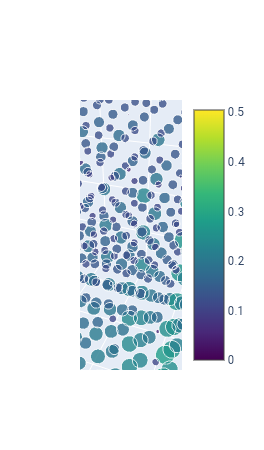

In [28]:
import plotly.graph_objects as go



fs = F[:,1].reshape(S,S,S).flatten()

trace1 = go.Scatter3d(
    x = grid[0].flatten(),
    y = grid[1].flatten(),
    z = grid[2].flatten(),
    mode='markers',
    marker=dict(
        size=fs/np.max(fs) * 20,
        color=fs,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        line=dict(width=0.8),
        showscale=True
    )
)

data = [trace1]
# layout = go.Layout(
#     scene = dict(
#                     xaxis = dict(
#                         title='XXXX-XXXXXX'),
#                     yaxis = dict(
#                         title='XXXX-XXXXXX'),
#                     zaxis = dict(
#                         title='XXXX-XXXXXX'),),
#     margin=dict(
#         r=20, b=10, l=10, t=10
#     )


fig = go.Figure(data=data)
    
fig.show()
#py.iplot(fig, filename='3d-scatter-colorscale')
# plot(fig, filename='D:\\plots\\3dplots\\xx.html')